In [63]:
# learning
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2

# file handling
from pathlib import Path
from shutil import copy

# image stuff
import numpy as np
from imageio import imread
from sklearn.feature_extraction import image

# measuring run time
import time

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

images_dir = Path('data/Onera Satellite Change Detection dataset - Images/')
labels_dir = Path('data/Onera Satellite Change Detection dataset - Train Labels/')

# creating parent folder for new data structure
preprocessed_dir = Path('data/preprocessed/')
if not preprocessed_dir.exists(): preprocessed_dir.mkdir()

In [2]:
# loading all raw data into new structure
def loading_data(dataset):
    
    pre_images_dir = preprocessed_dir / dataset / 'pre'
    if not pre_images_dir.exists(): pre_images_dir.mkdir(parents=True)
    
    post_images_dir = preprocessed_dir / dataset / 'post'
    if not post_images_dir.exists(): post_images_dir.mkdir(parents=True)
        
    clabels_dir = preprocessed_dir / dataset / 'labels'
    if not clabels_dir.exists(): clabels_dir.mkdir(parents=True)
    
    with open(images_dir / f'{dataset}.txt') as f:
        cities = f.read().strip('\n').split(',')
    print(cities)
    
    def move_png_to_preprocessed(city):
        
        # renaming and moving images and labels
        image_pair_dir = images_dir / city / 'pair'
        
        pre_image = image_pair_dir / 'img1.png'
        copy(str(pre_image), str(pre_images_dir / f'{city}_pre.png'))
        
        post_image = image_pair_dir / 'img2.png'
        copy(str(post_image), str(post_images_dir / f'{city}_post.png'))
        
        label = labels_dir / city / 'cm' / 'cm.png'
        copy(str(label), str(clabels_dir / f'{city}_label.png'))
        
    for city in cities:
        move_png_to_preprocessed(city)
        
    return cities
    
# cities = loading_data('test')
cities = loading_data('train')

['aguasclaras', 'bercy', 'bordeaux', 'nantes', 'paris', 'rennes', 'saclay_e', 'abudhabi', 'cupertino', 'pisa', 'beihai', 'hongkong', 'beirut', 'mumbai']


In [4]:
def sample_data(root_dir, cities, fraction=1e-6, patch_size=(15,15)):
    
    
    samples = []
    
    for city in cities:
        
        pre_file = root_dir / 'pre' / f'{city}_pre.png'
        post_file = root_dir / 'post' / f'{city}_post.png'
        label_file = root_dir / 'labels' / f'{city}_label.png'
        
        pre = imread(pre_file)[:,:,:3] / 255
        post = imread(post_file)[:,:,:3] / 255
        label = imread(label_file)[:,:,0] / 255
        
        # print(pre.shape, post.shape, label.shape)
        
        # stacking
        pre1 = pre[:,:,0]
        pre2 = pre[:,:,1]
        pre3 = pre[:,:,2]
        
        post1 = post[:,:,0]
        post2 = post[:,:,1]
        post3 = post[:,:,2]
        
        layers = [pre1, pre2, pre3, post1, post2, post3, label]
        
        stack = np.stack(layers, axis=-1)
        # print(stack.shape)
        
        patches = image.extract_patches_2d(stack, (15, 15), max_patches=0.001)
        
        # patches = extract_patches_2d(layers, patch_size=(15,15), max_patches=fraction) # maybe work with random state
        
        print(patches.shape)
        n_samples = patches.shape[0]
        for i in range(n_samples):
            pre_img = patches[i,:,:,:3]
            post_img = patches[i,:,:,3:6]
            label = patches[i,:,:,6][7,7]
        
            sample = {
                'pre': pre_img,
                'post': post_img,
                'change': label,
                'city': city
            }
        
            samples.append(sample)
        
        
    
    
    
    return samples

root_dir = Path('data/preprocessed/train/')
samples = sample_data(root_dir, cities, fraction=1e-6, patch_size=(15,15))
print(len(samples))


(233, 15, 15, 7)
(131, 15, 15, 7)
(224, 15, 15, 7)
(288, 15, 15, 7)
(148, 15, 15, 7)
(178, 15, 15, 7)
(421, 15, 15, 7)
(605, 15, 15, 7)
(774, 15, 15, 7)
(536, 15, 15, 7)
(673, 15, 15, 7)
(358, 15, 15, 7)
(1231, 15, 15, 7)
(458, 15, 15, 7)
6258


In [68]:
def initialize_weights(shape, name=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

Text(0.5, 1.0, 'Plot of weights initialized, with mean of 0.0 and standard deviation of 0.01')

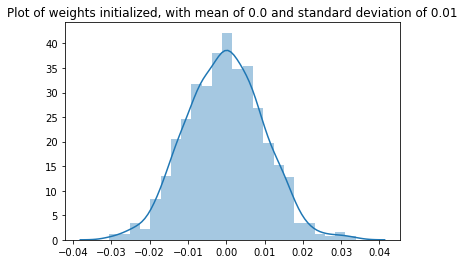

In [77]:
# Intialize bias with mean 0.0 and standard deviation of 10^-2
weights = initialize_weights((1000,1))
sns.distplot(weights)
plt.title("Plot of weights initialized, with mean of 0.0 and standard deviation of 0.01")

In [70]:
def initialize_bias(shape, name=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

Text(0.5, 1.0, 'Plot of biases initialized, with mean of 0.0 and standard deviation of 0.01')

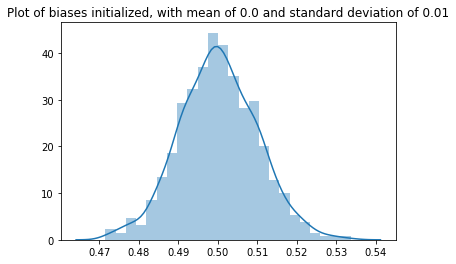

In [71]:
# Intialize bias with mean 0.5 and standard deviation of 10^-2
bias = initialize_bias((1000,1))
sns.distplot(bias)
plt.title("Plot of biases initialized, with mean of 0.0 and standard deviation of 0.01")

In [ ]:
def get_siamese_model(input_shape):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    model = keras.Sequential()
    # 32 convolution filters used each of size 3x3
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    # 64 convolution filters used each of size 3x3
    model.add(Conv2D(64, (3, 3), activation='relu'))
    # choose the best features via pooling
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # flatten since too many dimensions, we only want a classification output
    model.add(Flatten())
    # fully connected to get all relevant data
    model.add(Dense(128, activation='relu'))
    # output a softmax to squash the matrix into output probabilities
    model.add(Dense(10, activation='softmax'))
    
    
    
    
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    return siamese_net

In [90]:



def get_siamese_model(input_shape):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    model = keras.Sequential()
    # 32 convolution filters used each of size 3x3
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    # 64 convolution filters used each of size 3x3
    model.add(Conv2D(64, (3, 3), activation='relu'))
    # choose the best features via pooling
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # flatten since too many dimensions, we only want a classification output
    model.add(Flatten())
    # fully connected to get all relevant data
    model.add(Dense(128, activation='relu'))
    # output a softmax to squash the matrix into output probabilities
    model.add(Dense(10, activation='softmax'))
    
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    L1_layer = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    prediction = Dense(1,activation='sigmoid', bias_initializer=initialize_bias)(L1_distance)
    
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    return siamese_net

In [91]:
model = get_siamese_model((15, 15, 1))
model.summary()

TypeError: initialize_bias() got an unexpected keyword argument 'dtype'

In [10]:
class DataGeneratorSiamese(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, samples, batch_size=32, input_size=(15,15,3), shuffle=True):
        'Initialization'
        self.samples = samples
        self.batch_size = batch_size
        self.input_size = input_size
        self.patch_size = (input_size[0], input_size[1])
        self.shuffle = shuffle
        self.on_epoch_end()
        
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.samples))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.samples) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X_left, X_right, y = self.__data_generation(indexes)

        return X_left, X_right, y


    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' 
        # Initialization
        # X : (n_samples, *input_size)
        X_left = np.empty((self.batch_size, *self.input_size))
        X_right = np.empty((self.batch_size, *self.input_size))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, index in enumerate(indexes):
            sample = self.samples[index]
            X_left[i,] = sample['pre']
            X_right[i,] = sample['post']
            y[i] = sample['change']

        return X_left, X_right, y



(32, 15, 15, 3) (32, 15, 15, 3) (32,)


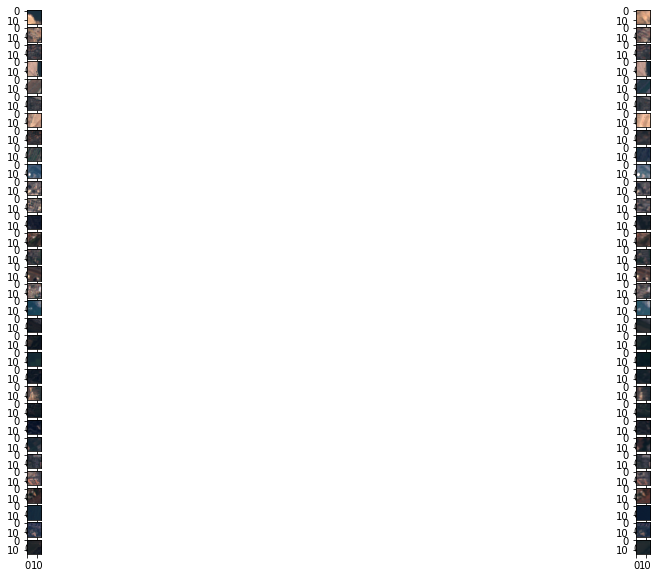

In [48]:
# dataloader test

datagenerator = DataGeneratorSiamese(samples)
batch = datagenerator.__getitem__(0)




def plot_batch(batch):
    
    X_left, X_right, y = batch
    print(X_left.shape, X_right.shape, y.shape)
    n_samples = y.shape[0]
    
    fig, axs = plt.subplots(n_samples, 2, figsize=(20,10))
    
    for i in range(n_samples):
        pre_img = X_left[i,:,:,:]
        post_img = X_right[i,:,:,:]
        label = y[i]
        
        axs[i,0].imshow(pre_img)
        axs[i,1].imshow(post_img)
        
        
    
plot_batch(batch)

In [75]:
INPUT_SIZE = (15, 15, 3)
BATCH_SIZE = 32

training_generator = DataGeneratorSiamese(samples, batch_size=BATCH_SIZE, input_size=INPUT_SIZE, shuffle=True)

model = get_siamese_model(INPUT_SIZE)


model.compile(optimizer=tf.optimizers.Adam(lr=0.00006), 
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Train model on dataset
# model.fit(x=training_generator, use_multiprocessing=False, workers=1, verbose=1, epochs=5)

TypeError: initialize_weights() got an unexpected keyword argument 'dtype'

In [44]:
from sklearn.datasets import load_sample_image
from sklearn.feature_extraction import image
# Use the array data from the first image in this dataset:
one_image = load_sample_image("china.jpg")
print('Image shape: {}'.format(one_image.shape))
patches = image.extract_patches_2d(one_image, (2, 2))
print('Patches shape: {}'.format(patches.shape))
# Here are just two of these patches:
print(patches[1])

Image shape: (427, 640, 3)
Patches shape: (272214, 2, 2, 3)
[[[174 201 231]
  [174 201 231]]

 [[173 200 230]
  [173 200 230]]]
